<a href="https://colab.research.google.com/github/timou0911/ML-DL-Learning/blob/main/Homework_BoW_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework4: Traffic Sign Classification

Using the data and some code from the practical exercises in class, perform the following tasks:

1. Experiment with the Bag-of-Words (BoW) feature extraction algorithm using different sizes of the dictionary. Plot the accuracy on the test set for each case.

2. Use Grid Search combined with Cross Validation to find the best parameters for the SVM model.

3. Replace SVM with other classifiers: K-Nearest Neighbors, Decision Tree, Random Forest. Compare the results and provide observations.

4. Use HOG to represent images and apply a classifier to classify the images.



## 0. Preparation

### 0-1. Data Preparation

In [1]:
import os
import gdown


# Create a directory if it doesn't exist
os.makedirs("datas", exist_ok=True)

# URL of the file to download
url = 'https://drive.google.com/drive/folders/10YmNykgL6CqT0nPlbhUEmiYc3RrJy3zC?usp=drive_link'

# Download the file into the data directory
gdown.download_folder(url, output='datas', quiet=False)
import warnings
warnings.filterwarnings('ignore')

!unzip /content/datas/datas.zip

Retrieving folder contents


Processing file 1kUC0TqmDwcOB4LluduPSyVJ1TCZX3EV8 datas.zip


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1kUC0TqmDwcOB4LluduPSyVJ1TCZX3EV8
From (redirected): https://drive.google.com/uc?id=1kUC0TqmDwcOB4LluduPSyVJ1TCZX3EV8&confirm=t&uuid=45c8d6e7-2e46-4199-bc43-75fac838928d
To: /content/datas/datas.zip
100%|██████████| 33.9M/33.9M [00:00<00:00, 90.4MB/s]
Download completed


Archive:  /content/datas/datas.zip
  inflating: datas/2_images/moon_dark.jpg  
  inflating: datas/2_images/NCKU_logo.png  
  inflating: datas/2_images/dark.jpg  
  inflating: datas/2_images/GuomLake.jpg  
  inflating: datas/3_images/messi.jpg  
  inflating: datas/1_images/2.jpg    
  inflating: datas/1_images/1.jpg    
  inflating: datas/1_images/5.jpg    
  inflating: datas/4_images/seed.png  
  inflating: datas/3_images/rice.png  
  inflating: datas/2_images/balloon.jpg  
  inflating: datas/5_images/man.png  
  inflating: datas/5_images/chessboard.jpg  
  inflating: datas/5_images/ville01002.jpg  
  inflating: datas/2_images/bright.jpg  
  inflating: datas/5_images/sudoku.png  
  inflating: datas/2_images/statue_bright.jpg  
  inflating: datas/2_images/unequalized.jpg  
  inflating: datas/4_images/lane2.png  
  inflating: datas/1_images/4.jpg    
  inflating: datas/1_images/3.jpg    
  inflating: datas/2_images/deer_salt.jpg  
  inflating: datas/5_images/house.jpg  
  inflating: data

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
import sklearn
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

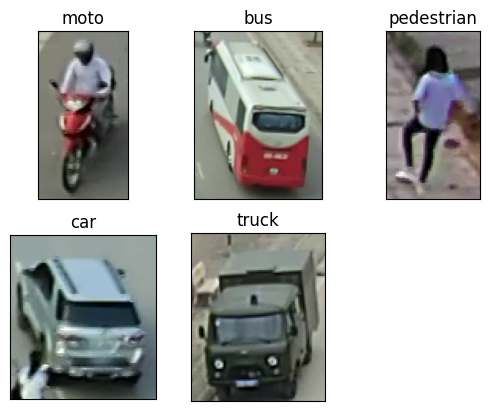

In [3]:
samples_list = []
samples_label = []
path_data_train = "datas/6_dataset/trainingset"
for label in os.listdir(path_data_train,):
    sample_file = os.listdir(os.path.join(path_data_train, label))[0]

    samples_list.append(cv2.imread(os.path.join(path_data_train, label, sample_file)))

    samples_label.append(label)

for i in range(len(samples_list)):
    plt.subplot(2, 3, i + 1), plt.imshow(cv2.cvtColor(samples_list[i], cv2.COLOR_BGR2RGB))
    plt.title(samples_label[i]), plt.xticks([]), plt.yticks([])

plt.show()

### 0-2. Data Statistics & Building a List to Store Images

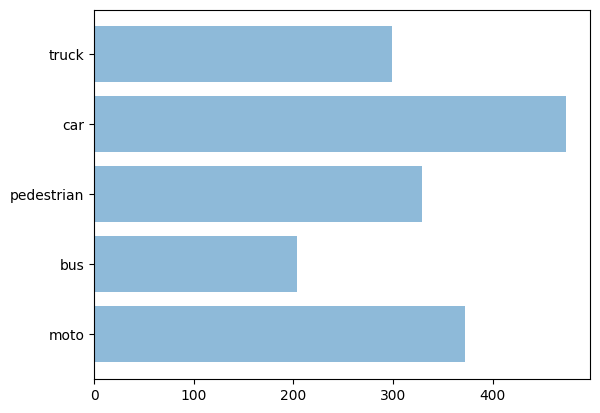

Total images: 1678


In [4]:
def statistic():
    label = []
    num_images = []
    for lab in os.listdir(path_data_train):
        label.append(lab)
        num_images.append(len(os.listdir(os.path.join(path_data_train, lab))))
    return label, num_images

label, num_images = statistic()

y_pos = np.arange(len(label))

plt.barh(y_pos, num_images, align='center', alpha=0.5)
plt.yticks(y_pos, label)
plt.show()

print('Total images: %d' %(sum(num_images)))

In [5]:
def read_data(label2id):
    X = []
    Y = []

    for label in os.listdir(path_data_train):
        for img_file in os.listdir(os.path.join(path_data_train, label)):
            img = cv2.imread(os.path.join(path_data_train, label, img_file))
            X.append(img)
            Y.append(label2id[label])
    return X, Y

# Label to id, used to convert string label to integer
label2id = {'pedestrian':0, 'moto':1, 'truck':2, 'car':3, 'bus':4}
X, Y = read_data(label2id)
print(len(X))
print(len(Y))
for i in range(10):
    print(X[i].shape)
    print(Y[i])

1678
1678
(111, 59, 3)
1
(82, 30, 3)
1
(99, 53, 3)
1
(73, 34, 3)
1
(115, 53, 3)
1
(67, 36, 3)
1
(105, 55, 3)
1
(91, 48, 3)
1
(127, 62, 3)
1
(117, 51, 3)
1


## 1. BoW Feature Extraction Using Different Sizes of the Dictionary

### 1-1. Extracting SIFT Features

In [6]:
def extract_sift_features(X):
    image_descriptors = []
    # sift = cv2.xfeatures2d.SIFT_create()
    sift = cv2.SIFT_create() ;
    for i in range(len(X)):
        _, des = sift.detectAndCompute(X[i], None)
        image_descriptors.append(des)

    return image_descriptors

image_descriptors = extract_sift_features(X)

print(len(image_descriptors))
print(type(image_descriptors[0][0]))
for i in range(10):
    print('Image {} has {} descriptors'.format(i, len(image_descriptors[i])))

1678
<class 'numpy.ndarray'>
Image 0 has 64 descriptors
Image 1 has 37 descriptors
Image 2 has 63 descriptors
Image 3 has 36 descriptors
Image 4 has 56 descriptors
Image 5 has 35 descriptors
Image 6 has 75 descriptors
Image 7 has 54 descriptors
Image 8 has 69 descriptors
Image 9 has 49 descriptors


### 1-2. Building the Dictionary (Bag-of-Words)

In [7]:
all_descriptors = []
for descriptors in image_descriptors:
    if descriptors is not None:
        for des in descriptors:
            all_descriptors.append(des)
print('Total number of descriptors: %d' %(len(all_descriptors)))

Total number of descriptors: 155516


In [8]:
def kmeans_bow(all_descriptors, num_clusters):
    bow_dict = []

    kmeans = KMeans(n_clusters=num_clusters).fit(all_descriptors)
    bow_dict = kmeans.cluster_centers_

    return bow_dict

### 1-3. Building Feature Vectors with BoW Model

In [9]:
from scipy.spatial.distance import cdist
def create_features_bow(image_descriptors, BoW, num_clusters):
    X_features = []

    for i in range(len(image_descriptors)):
        features = np.array([0] * num_clusters)

        if image_descriptors[i] is not None:
            distance = cdist(image_descriptors[i], BoW)
            argmin = np.argmin(distance, axis=1)

            for j in argmin:
                features[j] += 1

        X_features.append(features)


    return X_features

### 1-4. Find the Best Cluster Number

Accuracy for 40 clusters: 0.6875
Accuracy for 50 clusters: 0.7053571428571429
Accuracy for 60 clusters: 0.7351190476190477
Accuracy for 70 clusters: 0.7202380952380952
Accuracy for 80 clusters: 0.7202380952380952
Accuracy for 90 clusters: 0.7380952380952381
Accuracy for 100 clusters: 0.7380952380952381
Best model saved with 90 clusters and accuracy of 0.7380952380952381


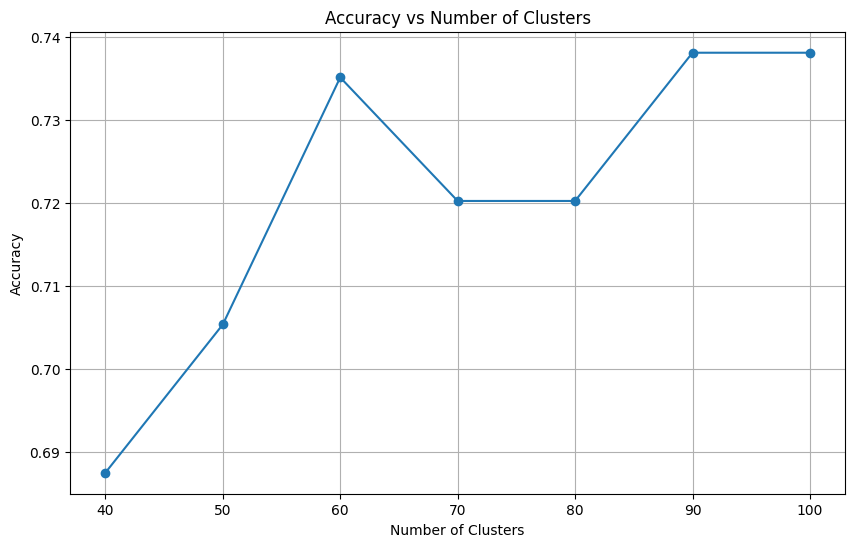

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

accuracies = []
cluster_numbers = range(40, 101, 10)
best_accuracy = 0
best_num_clusters = 0
best_X_features = None
best_svm = None

for num_clusters in cluster_numbers:
  BoW = kmeans_bow(all_descriptors, num_clusters)
  X_features = create_features_bow(image_descriptors, BoW, num_clusters)
  X_train, X_test, Y_train, Y_test = train_test_split(X_features, Y, test_size=0.2, random_state=42)
  id_train, id_test = train_test_split(range(len(X_features)), test_size=0.2, random_state=42)

  svm = sklearn.svm.SVC(C = 30)
  svm.fit(X_train, Y_train)
  y_pred = svm.predict(X_test)
  accuracy = accuracy_score(Y_test, y_pred)
  accuracies.append(accuracy)
  print(f"Accuracy for {num_clusters} clusters: {accuracy}")

  if accuracy > best_accuracy:
    best_accuracy = accuracy
    best_svm = svm
    best_num_clusters = num_clusters
    best_X_features = X_features
    best_bow = BoW

print(f"Best model saved with {best_num_clusters} clusters and accuracy of {best_accuracy}")

plt.figure(figsize=(10, 6))
plt.plot(cluster_numbers, accuracies, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Clusters')
plt.grid(True)
plt.show()

## 2. Find the Best Hyperparameters for SVM (Grid Search + Cross Validation)

### 2-1. Grid Search

In [12]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC

param_grid = {'C': [0.1, 1, 10, 100, 1000],
        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
        'kernel': ['rbf']}

X_train, X_test, Y_train, Y_test = train_test_split(best_X_features, Y, test_size=0.2, random_state=42)
id_train, id_test = train_test_split(range(len(X_features)), test_size=0.2, random_state=42)

svm = GridSearchCV(SVC(), param_grid, cv=5)
svm.fit(X_train, Y_train)
print('Best model', end='')
print(svm.best_estimator_)

Best modelSVC(C=10, gamma=0.001)


### 2-2. SVM Model & Evaluation

              precision    recall  f1-score   support

  pedestrian      0.750     0.814     0.780        59
        moto      0.816     0.816     0.816        76
       truck      0.704     0.864     0.776        44
         car      0.769     0.761     0.765       109
         bus      0.824     0.583     0.683        48

    accuracy                          0.771       336
   macro avg      0.772     0.768     0.764       336
weighted avg      0.775     0.771     0.769       336

Accuracy:  0.7708333333333334


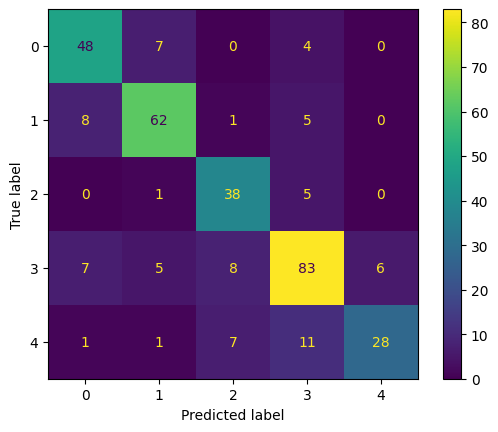

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay,  confusion_matrix , classification_report

Y_predict = svm.predict(X_test)
cm = confusion_matrix(Y_test, Y_predict, labels=svm.classes_)
ConfusionMatrixDisplay(cm, display_labels=svm.classes_).plot(values_format='d')
print(classification_report(Y_test, Y_predict, digits=3, target_names=list(label2id.keys())))
print("Accuracy: ", accuracy_score(Y_test, Y_predict))

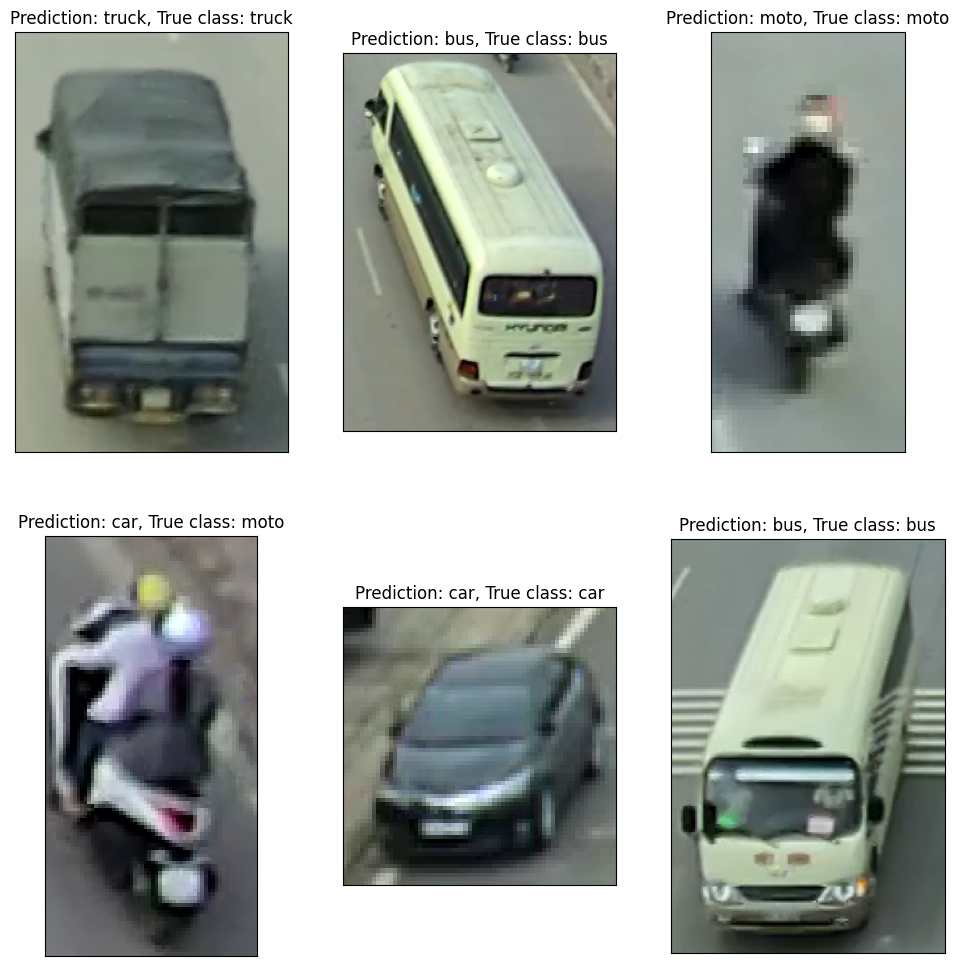

In [14]:
id2label = {j:i for i,j in label2id.items()} # reverse
plt.figure(figsize=(12, 12))
for i in range(6): # plot 6 images
    img_id = id_test[i] # X[img_id] is the i-th image in the test set
    plt.subplot(2, 3, i + 1), plt.imshow(cv2.cvtColor(X[img_id], cv2.COLOR_BGR2RGB))
    plt.title(f"Prediction: {id2label[Y_predict[i]]}, True class: {id2label[Y_test[i]]}"), plt.xticks([]), plt.yticks([])
plt.show()

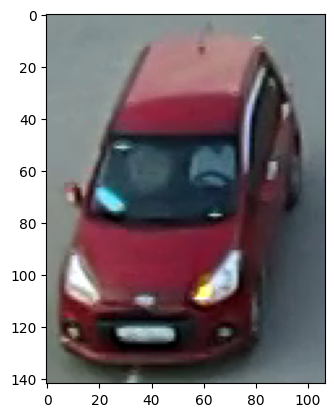

(142, 107, 3)


In [15]:
img = cv2.imread('datas/6_dataset/image_test/car.png')


plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

print(img.shape)
my_X = [img]

In [20]:
my_image_descriptors = extract_sift_features(my_X)
my_X_features = create_features_bow(my_image_descriptors, best_bow, best_num_clusters)

print(len(my_image_descriptors[0]))
print(my_X_features[0].shape)

106
(90,)


In [21]:
y_pred = svm.predict(my_X_features)

print(y_pred)
print(label2id)
# Get your label name using label2id variable (define above)
for key, value in label2id.items():
    if value == y_pred[0]:
        print('Your prediction: ', key)

[3]
{'pedestrian': 0, 'moto': 1, 'truck': 2, 'car': 3, 'bus': 4}
Your prediction:  car


## 3. Replace SVM with Random Forest

In [22]:
from sklearn.ensemble import RandomForestClassifier

dict_param = {
    'max_depth': [2, 3, 5, 7, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}

rf = GridSearchCV(estimator=RandomForestClassifier(), cv=5, param_grid=dict_param)
rf.fit(X_train, Y_train)
print('Best model', end='')
print(rf.best_estimator_)

Best modelRandomForestClassifier(criterion='entropy', max_depth=20, min_samples_leaf=5)


              precision    recall  f1-score   support

  pedestrian      0.763     0.763     0.763        59
        moto      0.693     0.803     0.744        76
       truck      0.667     0.773     0.716        44
         car      0.697     0.780     0.736       109
         bus      0.812     0.271     0.406        48

    accuracy                          0.708       336
   macro avg      0.726     0.678     0.673       336
weighted avg      0.720     0.708     0.693       336

Accuracy:  0.7083333333333334


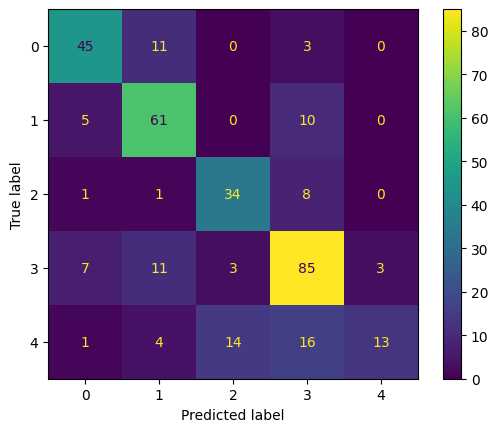

In [24]:
Y_predict = rf.predict(X_test)
cm = confusion_matrix(Y_test, Y_predict, labels=rf.classes_)
ConfusionMatrixDisplay(cm, display_labels=rf.classes_).plot(values_format='d')
print(classification_report(Y_test, Y_predict, digits=3, target_names=list(label2id.keys())))
print("Accuracy: ", accuracy_score(Y_test, Y_predict))

## 4. Use HOG to represent images and apply a classifier

In [ ]:
import skimage
from skimage.feature import hog

data_gray = [skimage.color.rgb2gray(img) for img in X]

hog_images = []
hog_features = []
plt.imshow(data_gray[0])

for img in data_gray:
    fd, hog_image = hog(img, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2', visualize=True)
    hog_images.append(hog_image)
    hog_features.append(fd)

print(len(hog_images))
print(len(hog_features))

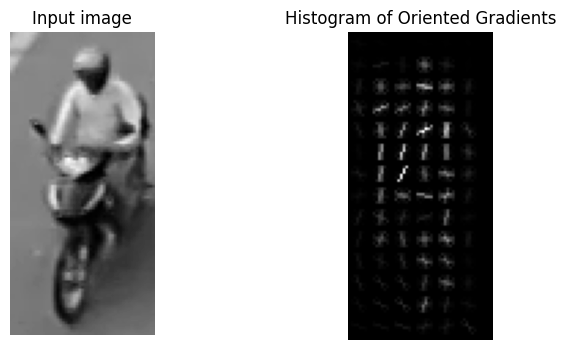

In [62]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(data_gray[0], cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = skimage.exposure.rescale_intensity(hog_images[51], in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [65]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(hog_features, Y, test_size=0.2, random_state=42)

clf = sklearn.svm.SVC(C=10, gamma=0.001)
clf.fit(X_train, Y_train)
y_pred = clf.predict(X_test)
cm = confusion_matrix(Y_test, Y_predict, labels=clf.classes_)
ConfusionMatrixDisplay(cm, display_labels=clf.classes_).plot(values_format='d')
print(classification_report(Y_test, Y_predict, digits=3, target_names=list(label2id.keys())))
print("Accuracy: ", accuracy_score(Y_test, Y_predict))

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (1342,) + inhomogeneous part.